## **Note!**

Make sure you install pygame in your terminal: \
pip install pygame

## **Prototype 2 - Interactive Environment**

This code will simulate interactive environment to the maze. We can add a block every time we left click on the path and remove a block every time we right click on the existing block. If we add or remove a block, the agent will find a new shortest path. If we block all the paths, the game will end. Press "R" to restart the game with the same maze, press "T" to restart with different maze.

**To test it, run the code**

In [ ]:
import pygame
import random
import heapq
import sys

# Constants
WIDTH, HEIGHT = 800, 600
CELL_SIZE = 20
ROWS = HEIGHT // CELL_SIZE
COLS = WIDTH // CELL_SIZE

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
ORANGE = (255, 165, 0)

def generate_maze(rows, cols):
    """Generate a new random maze with different structure each run"""
    while True:
        maze = [[1 for _ in range(cols)] for _ in range(rows)]
        start = (random.randint(0, rows-1), random.randint(0, cols-1))
        end = start
        while end == start:
            end = (random.randint(0, rows-1), random.randint(0, cols-1))

        # Maze generation using DFS with multiple paths
        stack = [start]
        maze[start[0]][start[1]] = 0
        directions = [(-1,0),(1,0),(0,-1),(0,1)]

        while stack:
            current = stack[-1]
            neighbors = []
            for dx, dy in directions:
                nx, ny = current[0]+dx*2, current[1]+dy*2
                if 0 <= nx < rows and 0 <= ny < cols and maze[nx][ny] == 1:
                    neighbors.append((nx, ny))

            if neighbors:
                next_cell = random.choice(neighbors)
                wall = (current[0]+(next_cell[0]-current[0])//2,
                        current[1]+(next_cell[1]-current[1])//2)
                maze[wall[0]][wall[1]] = 0
                maze[next_cell[0]][next_cell[1]] = 0
                stack.append(next_cell)
            else:
                stack.pop()

        # Add random connections
        for _ in range(rows * cols // 10):
            x, y = random.randint(0, rows-1), random.randint(0, cols-1)
            maze[x][y] = 0

        if astar(maze, start, end):
            return maze, start, end, [row[:] for row in maze]

# A* Pathfinding Algorithm
def astar(maze, start, end):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = { (r, c): float('inf') for r in range(ROWS) for c in range(COLS) }
    g_score[start] = 0
    f_score = { (r, c): float('inf') for r in range(ROWS) for c in range(COLS) }
    f_score[start] = heuristic(start, end)

    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == end:
            return reconstruct_path(came_from, current)

        for neighbor in get_neighbors(maze, current):
            tentative_g = g_score[current] + 1
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic(neighbor, end)
                if neighbor not in [i[1] for i in open_set]:
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(maze, pos):
    neighbors = []
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        nx, ny = pos[0]+dx, pos[1]+dy
        if 0 <= nx < ROWS and 0 <= ny < COLS:
            if maze[nx][ny] == 0:
                neighbors.append((nx, ny))
    return neighbors

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    return path[::-1]

def draw_text(surface, text, pos, size=30):
    font = pygame.font.SysFont(None, size)
    text_surface = font.render(text, True, RED)
    surface.blit(text_surface, pos)

# Initialize Pygame
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Dynamic Maze Pathfinder")

# Generate initial maze
maze, start, end, original_maze = generate_maze(ROWS, COLS)
path = astar(maze, start, end)
path_index = 0
game_over = False
agent_pos = start

def reset_game(new_maze=False):
    global maze, start, end, original_maze, path, path_index, game_over, agent_pos
    if new_maze:
        maze, start, end, original_maze = generate_maze(ROWS, COLS)
    else:
        maze = [row[:] for row in original_maze]
    path = astar(maze, start, end)
    path_index = 0
    game_over = False
    agent_pos = start

# Main loop
clock = pygame.time.Clock()
running = True

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        elif event.type == pygame.MOUSEBUTTONDOWN and not game_over:
            x, y = pygame.mouse.get_pos()
            col = x // CELL_SIZE
            row = y // CELL_SIZE

            if 0 <= row < ROWS and 0 <= col < COLS:
                if event.button == 1:  # Left click add block
                    if maze[row][col] == 0 and (row, col) != start and (row, col) != end:
                        maze[row][col] = 1
                elif event.button == 3:  # Right click remove block
                    if maze[row][col] == 1:
                        maze[row][col] = 0

                # Recalculate path from current position
                if path and path_index < len(path):
                    current_pos = path[path_index]
                    new_path = astar(maze, current_pos, end)
                    if new_path:
                        path = new_path
                        path_index = 0
                        agent_pos = current_pos
                    else:
                        game_over = True

        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_r:  # Reset current maze
                reset_game(new_maze=False)
            elif event.key == pygame.K_t:  # Generate new maze
                reset_game(new_maze=True)

    screen.fill(WHITE)

    # Draw maze walls
    for r in range(ROWS):
        for c in range(COLS):
            if maze[r][c] == 1:
                pygame.draw.rect(screen, BLACK,
                               (c*CELL_SIZE, r*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Draw start and end points
    pygame.draw.rect(screen, GREEN, (start[1]*CELL_SIZE, start[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))
    pygame.draw.rect(screen, BLUE, (end[1]*CELL_SIZE, end[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Draw projected path in orange from current position
    if path and not game_over and path_index < len(path):
        for p in path[path_index:]:
            pygame.draw.circle(screen, ORANGE,
                             (p[1]*CELL_SIZE + CELL_SIZE//2,
                              p[0]*CELL_SIZE + CELL_SIZE//2),
                             2)

    # Update and draw agent
    if path and not game_over and path_index < len(path):
        agent_pos = path[path_index]
        pygame.draw.circle(screen, RED,
                         (agent_pos[1]*CELL_SIZE + CELL_SIZE//2,
                          agent_pos[0]*CELL_SIZE + CELL_SIZE//2),
                         CELL_SIZE//3)
        path_index += 1
        if agent_pos == end:
            game_over = True

    # Game over display
    if game_over:
        text = "All paths blocked!" if agent_pos != end else "Destination reached!"
        draw_text(screen, text, (WIDTH//2 - 150, HEIGHT//2 - 50), 40)
        draw_text(screen, "R: Restart  T: New Maze", (WIDTH//2 - 140, HEIGHT//2 + 50), 30)

    pygame.display.flip()
    clock.tick(10)

pygame.quit()
sys.exit()

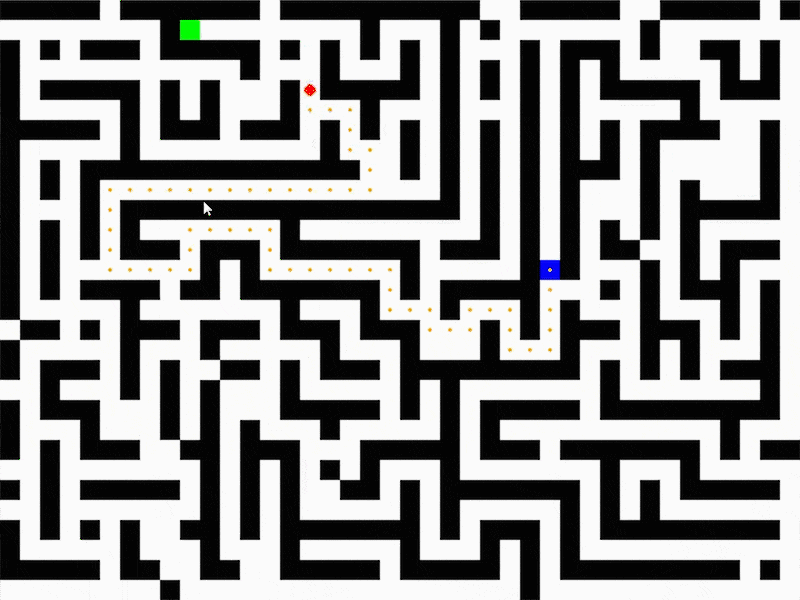